# Goal
Jacobo de la Cuesta-Zuluaga, July 2018.

While `PanX` provides a fancy visualization tool, it can be a little restrictive, therefore, I will perform some of the summary statistics and plotting in the present notebook.

# Init

In [1]:
# Libraries
library(tidyverse)
library(data.table)
library(UpSetR)
library(stringr)
library(reshape2)
library(RColorBrewer)
library(phangorn)
library(cowplot)
library(forcats)
library(vegan)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.2.1     ✔ purrr   0.3.2
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   0.8.3     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘data.table’

The following objects are masked from ‘package:dplyr’:

    between, first, last

The following object is masked from ‘package:purrr’:

    transpose


Attaching package: ‘reshape2’

The following objects are masked from ‘package:data.table’:

    dcast, melt

The following object is masked from ‘package:tidyr’:

    smiths

Loading required package: ape

********************************************************
Note: As of version 1.0.0, cowplot does not change the
  default ggplot2 theme anymore. To recover the previous
  behavior, execute:
  theme_set(theme_cowplot())
******

In [2]:
# R misc functions
source("/ebio/abt3_projects/vadinCA11/data/V11/R_utils/utils.R")

In [3]:
# Load itol scripts
itol_dir = "/ebio/abt3_projects/vadinCA11/data/V11/itol"
itol_code = file.path(itol_dir, "itol.R") 
source(file = itol_code)

# Var

In [4]:
# Plots dir
plots_dir = "/ebio/abt3_projects/vadinCA11/data/V11/out_plots"

In [5]:
# Read gene cluster table
gene_clust_raw = read.delim("/ebio/abt3_projects/vadinCA11/data/V11/panx_output/tables/gene_clust_summary.txt", 
                               stringsAsFactors=FALSE)

metadata_table = read.table("/ebio/abt3_projects/vadinCA11/data/V11/assemblies_metadata/Assembly_metadata_curated.txt",
                              sep = "\t", dec = ".", header = T, row.names = 1,
                              as.is = T, comment.char = "") %>% 
                            rownames_to_column(var = "Taxonomy")

# InterPro Annotation
# Gene Clusters
Interpro_raw = "/ebio/abt3_projects/vadinCA11/data/V11/cluster_annot/consensus.fasta.tsv" %>%
    read.delim(sep = "\t", na.strings=c("","NA"),  header = F)

colnames(Interpro_raw) = c("Cluster", "MD5", "Len", "Database", 
                           "Accession", "Description", "Start", 
                           "End", "e_Val", "Status", "Date", 
                           "Interpro_accession",  "Interpro_annot")

# Core methanogenesis proteins
Methano_core_annot = "/ebio/abt3_projects/vadinCA11/data/V11/assemblies_metadata/Methanogenesis_arCOGs.txt" %>% 
    read_tsv() %>% 
    column_to_rownames("X1") %>% 
    t() %>% 
    as.data.frame %>%
    select(arCOGs, Distribution, Product)
rownames(Methano_core_annot) = NULL

Methano_core_count = "/ebio/abt3_projects/vadinCA11/data/V11/assemblies_metadata/Methanogenesis_counts.txt" %>%
    read_tsv() %>%
    select(-X1) %>%
    select(Assembly = Genomes, everything())

# Phylogenetic tree 
# Load phylogenomic tree
#phylo_tree_file = file.path("/ebio/abt3_projects/vadinCA11/data/V11/anvio_output/phylogenomic_tree.txt")
phylo_tree_file = file.path("/ebio/abt3_projects/vadinCA11/data/V11/phylophlan/trees/RAxML_bipartitions.methanomassilii.tre")
phylogenomic_tree_raw = read.tree(phylo_tree_file)
phylogenomic_tree_raw$node.label = c() # solves the "Labels are not unique" message


# Root tree and remove root for downstream analyses
outgroup_clades = c("GCA_900090055", "GCA_000195915", "GCA_900176435", "GCA_000152265", "GCA_001402945")
phylogenomic_tree_raw = phylogenomic_tree_raw %>% root(., outgroup = outgroup_clades)
phylogenomic_tree = phylogenomic_tree_raw %>% drop.tip(., outgroup_clades)

Warning message:
“Missing column names filled in: 'X1' [1]”Parsed with column specification:
cols(
  .default = col_character()
)
See spec(...) for full column specifications.
Warning message:
“Missing column names filled in: 'X1' [1]”Parsed with column specification:
cols(
  .default = col_double(),
  Genomes = col_character()
)
See spec(...) for full column specifications.


In [6]:
# Name and symbol of COG categories
# From http://clovr.org/docs/clusters-of-orthologous-groups-cogs/
COG_name = c("RNA processing and modification" , "Chromatin structure and dynamics" , 
             "Energy production and conversion" , "Cell cycle control, cell division, chromosome partitioning" , 
             "Amino acid transport and metabolism" , "Nucleotide transport and metabolism" , 
             "Carbohydrate transport and metabolism" , "Coenzyme transport and metabolism" , 
             "Lipid transport and metabolism" , "Translation, ribosomal structure and biogenesis" ,
             "Transcription" , "Replication, recombination and repair" ,
             "Cell wall/membrane/envelope biogenesis" , "Cell motility" , 
             "Post-translational modification, protein turnover, and chaperones" , 
             "Inorganic ion transport and metabolism" ,
             "Secondary metabolites biosynthesis, transport, and catabolism" , 
             "Signal transduction mechanisms" , 
             "Intracellular trafficking, secretion, and vesicular transport" , "Defense mechanisms" , 
             "Extracellular structures" , "Nuclear structure" , "Cytoskeleton" ,
             "General function prediction only", "Function unknow" , "No annotation")


COG_symbol = c("A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "M", 
               "N", "O", "P", "Q", "T", "U", "V", "W", "Y", "Z", "R", "S", "X")

COG_definition = data.frame(Symbol = COG_symbol, Name = COG_name)

eggnog_header = c('query_name', 'seed_eggNOG_ortholog', 'seed_ortholog_evalue', 
                  'seed_ortholog_score', 'predicted_gene_name', 'GO_terms',
                  'KEGG_KOs', 'BiGG_reactions', 'Annotation_tax_scope', 
                  'OGs', 'bestOG|evalue|score', 'COG_cat', 'eggNOG_annot') 

#Load eggNOG mapper annotations
eggNOG_raw = "/ebio/abt3_projects/vadinCA11/data/V11/cluster_annot/eggNOG/Clusters.emapper.annotations" %>%
        read.delim(., header = F, sep = "\t", comment.char = "#", na.strings=c("","NA"))

colnames(eggNOG_raw) = eggnog_header

# Create a table retaining only one eggNOG annotation and COG category per cluster
eggNOG_clean = eggNOG_raw %>%
        mutate(NOG = factor(str_match(OGs, "[:alnum:]*@NOG"))) %>% 
        select(query_name, NOG, COG_cat, eggNOG_annot) %>%
        separate(COG_cat, into = c("COG_1", "COG_2", "COG_3"), sep = ",")

Warning message:
“Expected 3 pieces. Missing pieces filled with `NA` in 6724 rows [1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, ...].”

In [7]:
# Add Clade data to the metadata table and save
# Host Associated, Free Living and EXternal
HA_clade = c("GCA_002504405", "GCA_002506175", "GCA_002504495", "GCA_002506425", 
             "GCA_002503925", "GCA_002494805", "GCA_002498545", "GCA_002497475", 
             "GCA_002508595", "GCA_000800805", "GCA_002506905", "GCA_002496945", 
             "GCA_002495325", "GCA_002503545", "GCA_000300255", "V11_RL001", 
             "GCA_001481295", "GCA_900313075", "GCA_900314325", "GCA_002505245", 
             "GCA_002503785", "GCA_002506865", "GCA_002502545", "GCA_002509415", 
             "GCA_002498765", "GCA_002498785", "GCA_001421175", "GCA_002502965", 
             "GCA_002497155", "GCA_002509425", "GCA_002496785", "GCA_002505275", 
             "GCA_002506325", "GCA_002498605", "GCA_002509405", "GCA_002505345", 
             "GCA_002504645", "GCA_002502765", "GCA_002495665", "GCA_002506565", 
             "GCA_002508625", "GCA_002498425", "GCA_002498805", "GCA_002502925", 
             "GCA_002502465", "GCA_002498365", "GCA_002506995", "GCA_002494585", 
             "GCA_002509465", "GCA_002495495")

FL_clade = c("GCA_003153895", "GCA_003135935", "GCA_002506985", "GCA_002497075", 
             "GCA_000404225", "GCA_000308215", "GCA_002508545", "GCA_002494705", 
             "GCA_001421185", "GCA_002498285", "GCA_002495585", "GCA_002497995", 
             "GCA_002504525", "GCA_002496345", "GCA_002508585", "GCA_002508555", 
             "GCA_002502005", "GCA_002503495", "GCA_002505225", "GCA_002503645")

EX_clade = c("GCA_002496385", "GCA_002499085")

df_HA = data.frame(Assembly = HA_clade, 
                   clade = gsub(pattern = ".*", replacement = "HA", x = HA_clade, perl = T))
df_FL = data.frame(Assembly = FL_clade, 
                   clade = gsub(pattern = ".*", replacement = "FL", x = FL_clade, perl = T))
df_EX = data.frame(Assembly = EX_clade, 
                   clade = gsub(pattern = ".*", replacement = "EX", x = EX_clade, perl = T))

df_Clade = bind_rows(df_HA, df_FL, df_EX)

methanomassilii_data_raw = left_join(metadata_table, df_Clade, by = "Assembly")

methanomassilii_data_raw %>% dfhead

Warning message in bind_rows_(x, .id):
“Unequal factor levels: coercing to character”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“Unequal factor levels: coercing to character”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”

[1] 72 11


Taxonomy,Assembly,GC,Len,Genes,source_1,source_2,source_3,source_manual,location,clade
<chr>,<chr>,<dbl>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
Candidatus_Methanomethylophilus_alvus_Mx1201,GCA_000300255,0.5559482,1666795,1636,Host-associated,Feces,Human,Human_feces,NA,HA
Methanomassiliicoccus_luminyensis_B10,GCA_000308215,0.6047886,2620233,2607,Host-associated,Feces,Human,Human_feces,NA,FL
Candidatus_Methanomassiliicoccus_intestinalis_Issoire_Mx1,GCA_000404225,0.4125543,1931651,1855,Host-associated,Feces,Human,Human_feces,NA,FL


In [8]:
# Given that Interpro returns multiple hits from different DBs
# I will only use the most frequent Interpro ID for a given cluster
# I can always come back to the original Interpro table if needed

# Remove NAs from annotation and determine the most frequent ID
# If ties use the first
best_IPR_annot = Interpro_raw %>%
    filter(!is.na(Interpro_accession)) %>%
    group_by(Cluster, Interpro_accession) %>%
    tally() %>%
    mutate(rank = row_number(-n)) %>%
    filter(rank == 1) %>%
    ungroup %>%
    select(-c(n,rank))

# Create table with the annotation of a given ID
IPR_acc_annot = Interpro_raw %>% 
    select(Interpro_accession, Interpro_annot) %>%
    group_by(Interpro_accession, Interpro_annot) %>%
    filter(!is.na(Interpro_accession) & row_number() == 1) %>%
    ungroup()

# Annotation of each gene cluster
clust_IPR_annot = left_join(IPR_acc_annot, best_IPR_annot, by = "Interpro_accession") %>% 
    filter(!is.na(Cluster))

# Create a single table with all annotations
# Add eggNOG annotations
cluster_table = left_join(gene_clust_raw, eggNOG_clean, by = c("MSA" = "query_name"))
# Add InterPro annotations
cluster_table = left_join(cluster_table, clust_IPR_annot, by = c("MSA" = "Cluster"))


cluster_table = cluster_table %>% 
    select(Gene_ID, MSA, Gene_Name, Annotation, Count, NOG, COG_1, 
    eggNOG_annot, Interpro_accession, Interpro_annot, 
    starts_with("GCA"), starts_with("V11_RL001"))  %>%
    mutate(COG_1 = case_when(is.na(COG_1) ~ "X", TRUE ~ as.character(COG_1))) %>%
    mutate(COG_1 = factor(COG_1, levels = COG_symbol))

cluster_table %>% dfhead

Warning message:
“Factor `Interpro_accession` contains implicit NA, consider using `forcats::fct_explicit_na`”Warning message:
“Factor `Interpro_annot` contains implicit NA, consider using `forcats::fct_explicit_na`”Warning message:
“Column `MSA`/`query_name` joining character vector and factor, coercing into character vector”Warning message:
“Column `MSA`/`Cluster` joining character vector and factor, coercing into character vector”

[1] 13695    82


Gene_ID,MSA,Gene_Name,Annotation,Count,NOG,COG_1,eggNOG_annot,Interpro_accession,Interpro_annot,⋯,GCA_002508625,GCA_002509405,GCA_002509415,GCA_002509425,GCA_002509465,GCA_003135935,GCA_003153895,GCA_900313075,GCA_900314325,V11_RL001
<int>,<chr>,<chr>,<chr>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,GC00000267,None,GPN-loop GTPase,72,COG1100@NOG,S,Conserved hypothetical ATP binding protein,IPR004130,GPN-loop GTPase,⋯,1,1,1,1,1,1,1,1,1,1
2,GC00000268,None,hypothetical protein,72,COG1813@NOG,K,transcriptional regulator XRE family,IPR001387,Cro/C1-type helix-turn-helix domain,⋯,1,1,1,1,1,1,1,1,1,1
3,GC00000291,top6A,Type 2 DNA topoisomerase 6 subunit A,72,COG1697@NOG,L,DNA topoisomerase VI subunit A (EC 5.99.1.3),IPR004085,"DNA topoisomerase VI, subunit A",⋯,1,1,1,1,1,1,1,1,1,1


In [9]:
# Export annotated cluster table
cluster_table_file = "/ebio/abt3_projects/vadinCA11/data/V11/cluster_annot/Gene_cluster_annots.tsv"
write_tsv(cluster_table, cluster_table_file)

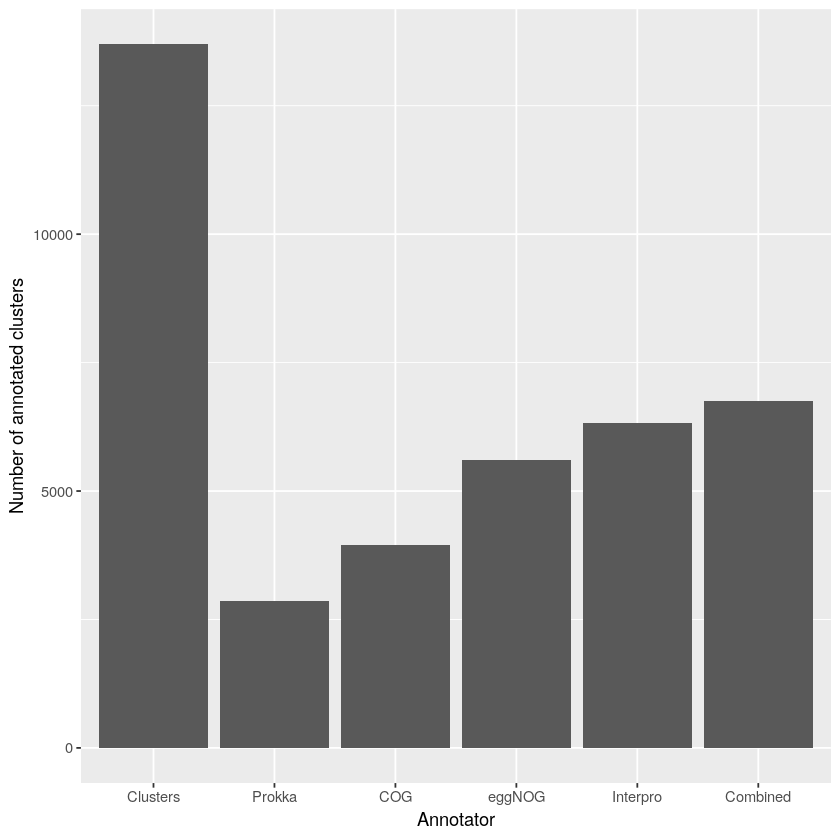

In [10]:
# Number of annotated clusters
clust_annotations = cluster_table %>%
    select(MSA, matches("annot"), COG_1) %>%
    mutate(Annotation = na_if(Annotation, "hypothetical protein"))

All_clust = clust_annotations %>%
    summarise(n = n()) 

N_prokka = clust_annotations %>%
    filter(!is.na(Annotation)) %>%
    summarise(n = n())

N_eggNOG = clust_annotations %>%
    filter(!is.na(eggNOG_annot)) %>%
    summarise(n = n())

N_InterPro = clust_annotations %>%
    filter(!is.na(Interpro_annot)) %>%
    summarise(n = n())

N_COG = clust_annotations %>%
    filter((!COG_1 %in% c("S", "X"))) %>%
    summarise(n = n())

Annot_clust = clust_annotations %>%
    filter(!is.na(Interpro_annot) | !is.na(eggNOG_annot) | !is.na(Annotation) | (!COG_1 %in% c("S", "X"))) %>%
    summarise(n = n())

Annotator = c("Clusters", "Prokka", "COG", "eggNOG", "Interpro", "Combined") %>%
    factor(x = ., levels = .)

N_annot = bind_rows(All_clust, N_prokka,  N_COG, N_eggNOG, N_InterPro, Annot_clust) %>%
    mutate(Annotator)

N_annot %>%
    ggplot(aes(x = Annotator, y = n)) +
    geom_bar(stat = "identity") +
    labs(y = "Number of annotated clusters")

[1] 6745    5


MSA,Annotation,eggNOG_annot,Interpro_annot,COG_1
<chr>,<chr>,<fct>,<fct>,<fct>
GC00000267,GPN-loop GTPase,Conserved hypothetical ATP binding protein,GPN-loop GTPase,S
GC00000268,NA,transcriptional regulator XRE family,Cro/C1-type helix-turn-helix domain,K
GC00000291,Type 2 DNA topoisomerase 6 subunit A,DNA topoisomerase VI subunit A (EC 5.99.1.3),"DNA topoisomerase VI, subunit A",L


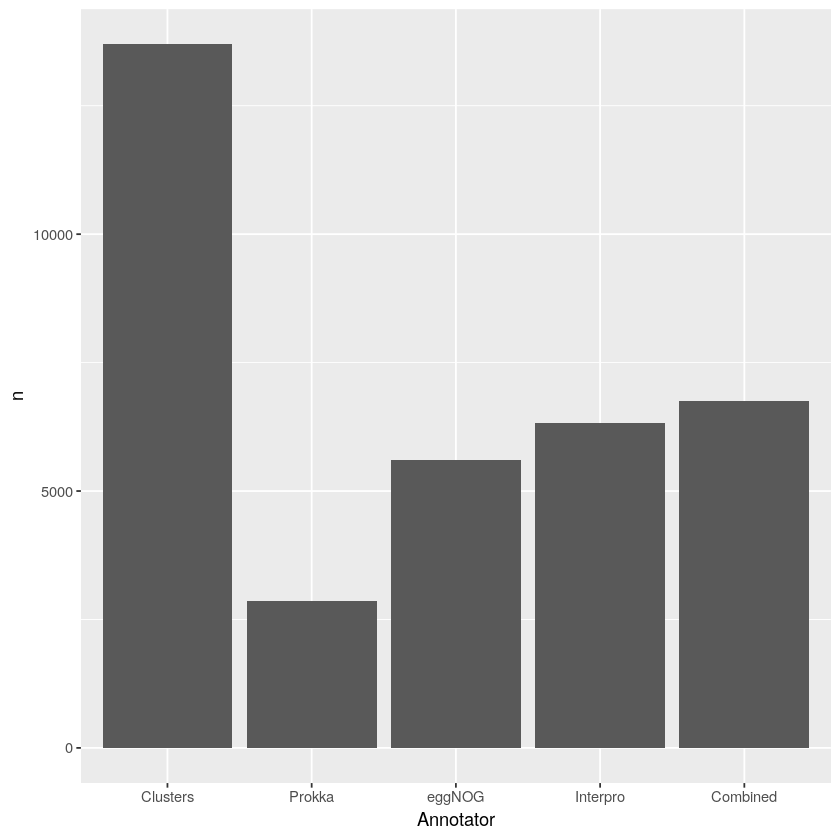

In [11]:


Annotator = c("Clusters", "Prokka", "eggNOG", "Interpro", "Combined") %>%
    factor(x = ., levels = .)

N_annot = bind_rows(All_clust, N_prokka, N_eggNOG, N_InterPro, Annot_clust) %>%
    mutate(Annotator)

N_annot %>%
    ggplot(aes(x = Annotator, y = n)) +
    geom_bar(stat = "identity")

clust_annotations %>%
    filter(!is.na(Interpro_annot) | !is.na(eggNOG_annot) | !is.na(Annotation)) %>%
    dfhead

## Colors

In [12]:
# Palette with colors of all qualitative palletes
# Extract all qual palettes
qual_col_pals = brewer.pal.info %>% 
    rownames_to_column() %>% 
    filter(rowname %in% c("Paired", "Set3"))
# Create single vector with all colors
col_vector = map2(qual_col_pals$maxcolors, qual_col_pals$rowname, brewer.pal) %>% 
    unlist %>%
    c(., "#696969", "#000000")
names(col_vector) = as.character(COG_symbol)

# Eukaryote-like proteins

## Search clusters annotated as ELPs

I will first perform a directed approach, in which I will look into the presence of eukaryote-like proteins and other symbiosis factors present in the different genomes. The factors I will investigate, and the search terms I will include are:

* Adhesin-like proteins (ALPs): `Parallel beta-helix repeat`
* Sel1 containing proteins (Sel1): `Sel1`
* Listeria-Bacteroides repeat containing proteins (List-Bact): `Listeria-Bacteroides`
* Tetratrico peptide repeats (TPRs): `Tetratrico` 
* Ankyrin repeats (ANKs): `Ankyrin`
* Leucine-rich repeats (LRRs): `Leucine-rich`
* Fibronectin type III (fn3) domains: `Fibronectin type III`
* Laminin G domain: `Laminin G`
* Bacterial Ig-like domains: `Ig-like`
* YadA-like domain (Yersinia adhesin A): `YadA` 
* TadE-like domain: `TadE` 
* Invasion protein B (ialB): `Invasion protein B`

In [13]:
ELPs = c("ALP" = "Parallel beta-helix repeat", "Sel1" = "Sel1", 
         "List_Bact" = "Listeria", "TPR" = "Tetratrico", 
         "ANK" = "Ankyrin", "LRR" = "Leucine-rich", "FN3" = "Fibronectin type III", 
         "Laminin_G" = "Laminin G", "Ig_like" = "Ig-like", 
         "YadA" = "YadA", "TadE" = "TadE", "ialB" = "Invasion protein B")

In [14]:
# Create a table with all clusters annotated as the above ELPs
filter_interpro = function(df, value, prot_name){
    
    clusters = df %>% 
        filter(str_detect(Interpro_annot, value)) %>%
        select(Cluster) %>%
        unique()
    
    clusters = clusters %>% 
        mutate(ELP = rep(prot_name, nrow(clusters)))
        
    clusters
}
# filter_interpro(Interpro_raw, "Sel1")
ELP_cluster_ID = map2_df(ELPs, names(ELPs), function(x, y) filter_interpro(Interpro_raw, x, y))

In [15]:
ELP_cluster_ID %>% dfhead

[1] 519   2


Cluster,ELP
<fct>,<chr>
GC00000677_21,ALP
GC00000677_5,ALP
GC00001751_r1_1,ALP


## Filter gene cluster table

In [16]:
# Create a table with ELPs and cluster names with the counts on each genome
ELP_cluster_table = cluster_table %>% 
    filter(MSA %in% ELP_cluster_ID$Cluster) %>%
    left_join(ELP_cluster_ID, by = c("MSA" = "Cluster")) %>% 
    select(Gene_ID, MSA, ELP, starts_with("GCA"), starts_with("V11"))

Warning message:
“Column `MSA`/`Cluster` joining character vector and factor, coercing into character vector”

In [17]:
ELP_cluster_table %>% dfhead

[1] 481  75


Gene_ID,MSA,ELP,GCA_000300255,GCA_000308215,GCA_000404225,GCA_000800805,GCA_001421175,GCA_001421185,GCA_001481295,⋯,GCA_002508625,GCA_002509405,GCA_002509415,GCA_002509425,GCA_002509465,GCA_003135935,GCA_003153895,GCA_900313075,GCA_900314325,V11_RL001
<int>,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
289,GC00000590,TPR,1,1,1,1,1,1,1,⋯,1,1,1,0,1,1,1,1,1,1
623,GC00000118_r1_r1_r1_1_p2,TPR,1,2,1,1,1,2,1,⋯,1,1,0,1,1,1,1,1,1,1
640,GC00000706_r1_1,TPR,1,1,0,1,1,1,1,⋯,1,1,0,1,1,1,1,1,0,1


In [18]:
# Create table with the count of genes/clusters of each ELP in each genome 
ELP_Sum = ELP_cluster_table %>%
    select(-Gene_ID) %>%
    group_by(ELP) %>%
    summarise_if(is.numeric, .funs = sum) 

# Long form
ELP_Sum_long = ELP_Sum %>%
    gather(key = "Genome", value = "Count", 2:ncol(ELP_Sum))

# Add clade information
ELP_Sum_long = left_join(ELP_Sum_long, df_Clade, by = c("Genome" = "Assembly"))

In [19]:
ELP_Sum_long %>%
    group_by(ELP, clade) %>%
    summarise(mean = mean(Count, na.rm = T))

ELP,clade,mean
<chr>,<chr>,<dbl>
ALP,EX,9.00
ALP,FL,2.25
ALP,HA,0.14
ANK,EX,0.00
ANK,FL,0.10
ANK,HA,0.10
FN3,EX,7.50
FN3,FL,4.55
FN3,HA,0.32


In [20]:
# Save ELPs table
ELPs_File = "/ebio/abt3_projects/vadinCA11/data/V11/itol/ELPs.tsv"

# Transpose table
ELP_Sum_export = ELP_Sum %>% 
    select(-ELP) %>% 
    t %>% 
    as.data.frame %>% 
    rownames_to_column
    
colnames(ELP_Sum_export) =  c("Assembly", ELP_Sum$ELP)
ELP_Sum_export %>% dfhead

ELP_Sum_export %>% write_delim(., path = ELPs_File, delim = '\t', col_names = T)

[1] 72 10


Assembly,ALP,ANK,FN3,Ig_like,List_Bact,LRR,Sel1,TPR,YadA
<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
GCA_000300255,0,0,0,0,6,1,28,37,0
GCA_000308215,2,0,5,1,2,5,1,11,0
GCA_000404225,1,1,0,1,26,7,6,15,0


# Gene cluster size spectrum

## Tables and stats

In [21]:
# Transform counts to presence/absence table
cluster_pres_abs = cluster_table %>%
    select(starts_with("GCA"), starts_with("V11")) %>%
    decostand(., method = "pa")

clust_tmp = cluster_table %>%
    select(-starts_with("GCA"), -starts_with("V11"))

cluster_pres_abs = bind_cols(clust_tmp, cluster_pres_abs)

# Add number of genomes of each clade in each cluster
cluster_pres_abs = cluster_pres_abs %>% 
    select(HA_clade) %>% 
    rowSums() %>%
    mutate(cluster_pres_abs, Count_HA = .)

cluster_pres_abs = cluster_pres_abs %>% 
    select(FL_clade) %>% 
    rowSums() %>%
    mutate(cluster_pres_abs, Count_FL = .)

cluster_pres_abs = cluster_pres_abs %>% 
    select(EX_clade) %>% 
    rowSums() %>%
    mutate(cluster_pres_abs, Count_EX = .)

In [325]:
# Cluster size
cluster_pres_abs %>% 
    count(Count) %>%
    mutate(prop = 100 * (n/sum(n)))

Count,n,prop
<int>,<int>,<dbl>
1,7990,58.34246075
2,2002,14.61847390
3,573,4.18400876
4,316,2.30741146
5,229,1.67214312
6,175,1.27783863
7,101,0.73749544
8,90,0.65717415
9,71,0.51843739


## Plots

In [22]:
# Create a function to plot from the complete cluster table
cluster_spectrum = function(clust_tab, counts, categories){
    table_COGs = clust_tab %>% 
        group_by(eval(parse(text = counts)), eval(parse(text = categories))) %>%
        summarise(n_clusters = n())
    names(table_COGs) = c("Count", "Category", "n_clusters")
    
    table_COGs = table_COGs %>% 
        as.data.frame %>% 
        filter(Count != 0)
    
    max_break = table_COGs %>% pull(Count) %>% max
    
    table_COGs %>%
        ggplot(aes(x = Count, y = (n_clusters), color = Category)) +
            geom_line() +
                labs(x = "Genomes in cluster", y = "Number of clusters", color = "COG category") +
                scale_x_continuous(breaks=seq(0, max_break, 10)) + 
                scale_color_manual(values=col_vector) +
                theme_light() +
                theme(panel.grid.major = element_blank(), 
                      panel.grid.minor = element_blank(), 
                      legend.position = "none")
   
}

In [23]:
# Plots of gene cluster spectrum
# By clade and separating known and unknown clusters
# Mmassilii
Mmassilii_spectrum_u = cluster_pres_abs %>% 
    filter(COG_1 %in% c("X", "S")) %>% 
    cluster_spectrum(., "Count", "COG_1")

Mmassilii_spectrum_k = cluster_pres_abs %>% 
    filter(!(COG_1 %in% c("X", "S"))) %>% 
    cluster_spectrum(., "Count", "COG_1")

# HA
HA_spectrum_u = cluster_pres_abs %>% 
    filter(COG_1 %in% c("X", "S")) %>% 
    cluster_spectrum(., "Count_HA", "COG_1")

HA_spectrum_k = cluster_pres_abs %>% 
    filter(!(COG_1 %in% c("X", "S"))) %>% 
    cluster_spectrum(., "Count_HA", "COG_1")

# FL
FL_spectrum_u = cluster_pres_abs %>% 
    filter(COG_1 %in% c("X", "S")) %>% 
    cluster_spectrum(., "Count_FL", "COG_1")

FL_spectrum_k = cluster_pres_abs %>% 
    filter(!(COG_1 %in% c("X", "S"))) %>% 
    cluster_spectrum(., "Count_FL", "COG_1")

#EX
EX_spectrum_u = cluster_pres_abs %>% 
    filter(COG_1 %in% c("X", "S")) %>% 
    cluster_spectrum(., "Count_EX", "COG_1")

EX_spectrum_k = cluster_pres_abs %>% 
    filter(!(COG_1 %in% c("X", "S"))) %>% 
    cluster_spectrum(., "Count_EX", "COG_1")

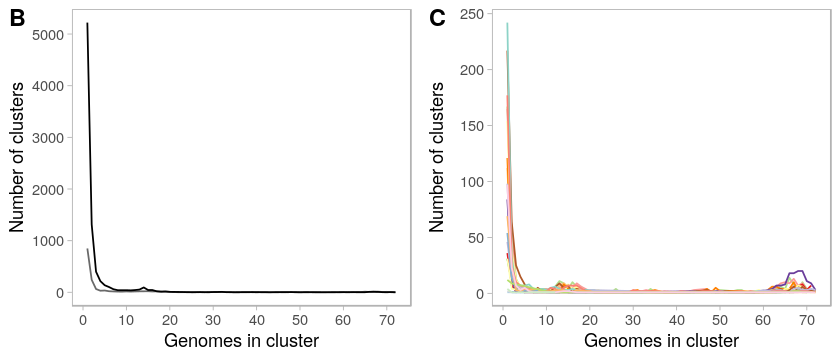

In [24]:
# Print plot
options(repr.plot.width = 7, repr.plot.height = 3)
Mmassilii_spectrumplt = plot_grid(Mmassilii_spectrum_u, Mmassilii_spectrum_k,
          nrow = 1, labels = c("B", "C"), align = "v")
plot(Mmassilii_spectrumplt)

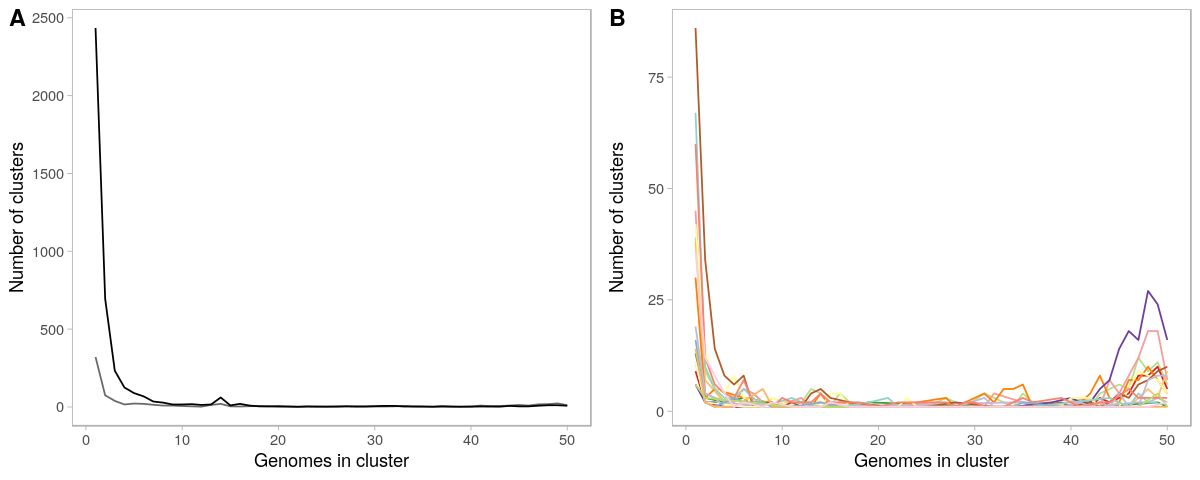

In [25]:
# Print plot
options(repr.plot.width = 10, repr.plot.height = 4)
plot_grid(HA_spectrum_u, HA_spectrum_k,
          nrow = 1, labels = "AUTO", align = "v")

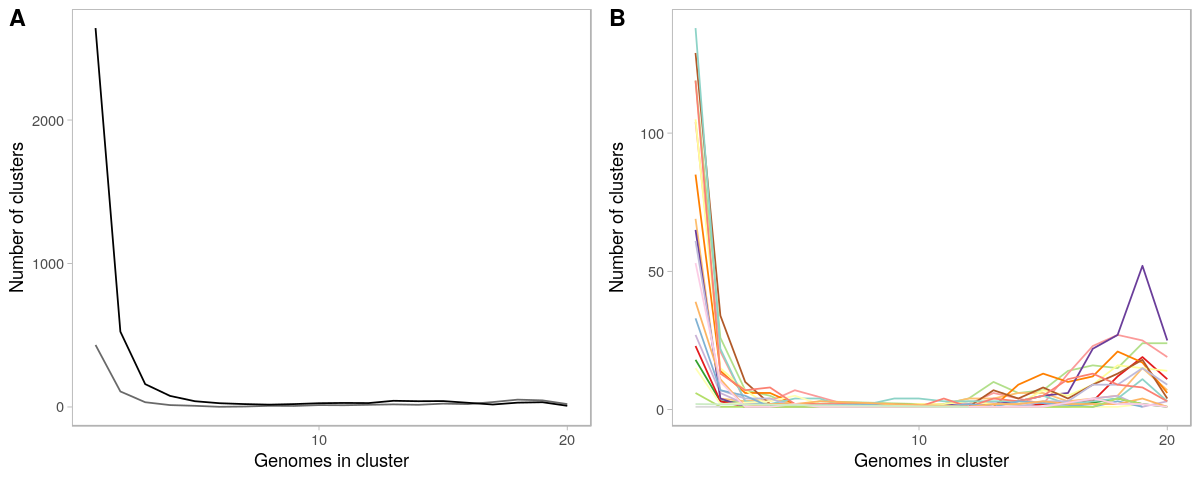

In [26]:
# Print plot
options(repr.plot.width = 10, repr.plot.height = 4)
plot_grid(FL_spectrum_u, FL_spectrum_k,
          nrow = 1, labels = "AUTO", align = "v")

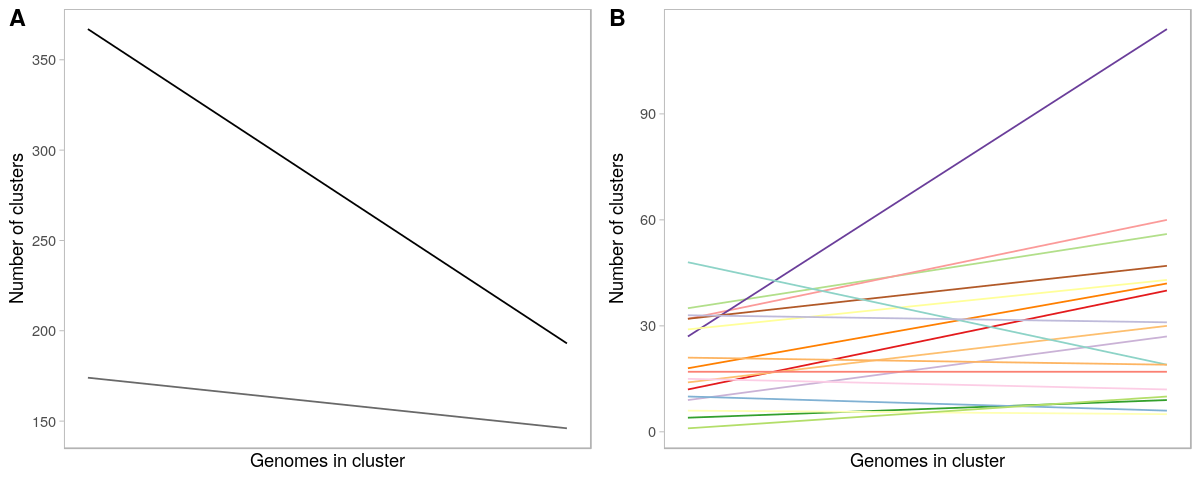

In [27]:
# Print plot
options(repr.plot.width = 10, repr.plot.height = 4)
plot_grid(EX_spectrum_u, EX_spectrum_k,
          nrow = 1, labels = "AUTO", align = "v")

# Clusters unique to each clade

## Core genes of *Methanomassiliicoccales* and each clade

According to [Collins et al (2011)](https://doi.org/10.1186/1471-2105-12-S14-S9), the size distribution of gene cluster in bacterial and archaeal genomes follows the same pattern I observed for the complete order and each of the clades. I will focus on the gene clusters located in the right side of the spectrum, which correspond to genes present in most of the analyzed genomes. My reasoning is that these genes would provide better information regarding the differences in adaptation between clades. I will consider genes present in at least 80% of the genomes of a given cluster as the 'soft-core'.

In [28]:
# Determine the core of each clade and the complete order
core_cutoff = 0.8

core_Mmassilii = cluster_pres_abs %>% 
    filter(Count >= (72 * core_cutoff) & Count_FL > 0 & Count_HA > 0 & Count_EX > 0)
    
core_HA = cluster_pres_abs %>% 
    filter(Count_HA >= (length(HA_clade) * core_cutoff))

core_FL = cluster_pres_abs %>% 
    filter(Count_FL >= (length(FL_clade) * core_cutoff))

core_EX = cluster_pres_abs %>% 
    filter(Count_EX >= (length(EX_clade) * core_cutoff))

In [29]:
# Determine unique clusters of each clade
# i.e, clusters present in the core of a clade and absent in the others
unique_HA = core_HA %>%
    filter(Count_FL == 0 & Count_EX == 0)

unique_FL = core_FL %>%
    filter(Count_HA == 0 & Count_EX == 0)

unique_EX = core_EX %>%
    filter(Count_FL == 0 & Count_HA == 0)

## Plot proportion of COG categories by presence/absence

In [30]:
# Function to obtain the fraction labeled as each COG
COG_summary = function(clst, set_name) {
    clst %>% 
        group_by(COG_1) %>% 
        summarise(n = n()) %>%
        mutate(Proportion = n/sum(n), Clade = rep(set_name, nrow(.)))
}

In [31]:
COG_summaries = COG_summary(core_Mmassilii, "Methanomassilii-Shell")

COG_summaries = COG_summary(core_HA, "HA-Shell") %>% bind_rows(., COG_summaries)
COG_summaries = COG_summary(core_FL, "FL-Shell") %>% bind_rows(., COG_summaries)
COG_summaries = COG_summary(core_EX, "EX-Shell") %>% bind_rows(., COG_summaries)

COG_summaries = COG_summary(unique_HA, "HA-Unique") %>% bind_rows(., COG_summaries)
COG_summaries = COG_summary(unique_FL, "FL-Unique") %>% bind_rows(., COG_summaries)
COG_summaries = COG_summary(unique_EX, "EX-Unique") %>% bind_rows(., COG_summaries)

In [32]:
Shell_levels = c("Methanomassilii-Shell", "HA-Shell", "FL-Shell", "EX-Shell", "HA-Unique", "FL-Unique", "EX-Unique")
COG_summaries = COG_summaries %>% 
    mutate(Clade = factor(Clade, levels = Shell_levels))

In [363]:
COG_lvls = c("A", "B", "J", "K", "L", "D", "M", "N", "O", "T", "U", "V", "W", 
             "Y", "Z", "C", "E", "F", "G", "H", "I", "P", "Q", "X", "S") %>% rev

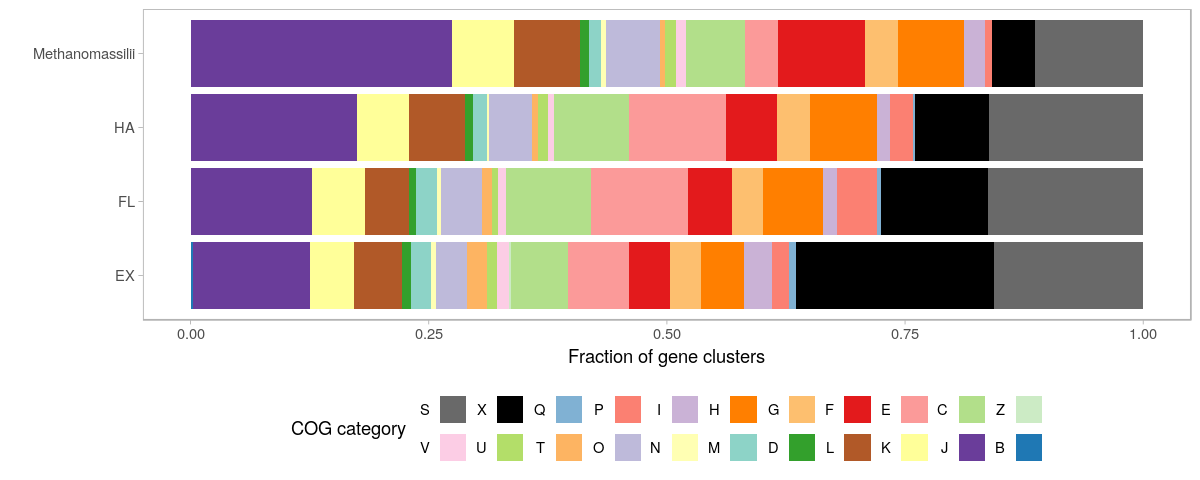

In [371]:
options(repr.plot.width = 10, repr.plot.height = 4)

COG_summaries_plt = COG_summaries %>%
    filter(str_detect(Clade, "Methano") | str_detect(Clade, "-Shell")) %>%
    mutate(Clade = str_remove_all(Clade, "-Shell"), 
           COG_1 = fct_relevel(COG_1, COG_lvls))

cog_barplt_pa = COG_summaries_plt %>%
    #filter(str_detect(Clade, "Methano") | str_detect(Clade, "-Shell")) %>%
    ggplot(., aes(x = Clade, y = Proportion, fill = COG_1)) + 
        geom_bar(stat="identity", position="fill") + 
        scale_fill_manual(values=col_vector) +
        theme_light() +
        labs(y = "Fraction of gene clusters", x = " ", fill = "COG\nCategoty") +
        coord_flip() +
        theme(legend.position="bottom", 
              panel.grid.major = element_blank(), 
              panel.grid.minor = element_blank()) +
        guides(fill = guide_legend(title = "COG category", label.position = "left",
                                   nrow = 2, byrow = TRUE))
plot(cog_barplt_pa)

## Plot proportion of COG categories by gene cluster count

In [550]:
# Methanomassiliicoccales
Genomes_clade = methanomassilii_data_raw %>%
    select(Genome = Assembly, clade)

# Cluster count table in long format
core_Mmassilii_copies = cluster_table %>% 
    filter(MSA %in% core_Mmassilii$MSA) %>%
    select(MSA, COG_1, starts_with("GCA"), V11_RL001) %>% 
    gather(Genome, n, -c(MSA, COG_1))  %>%
    left_join(., Genomes_clade, by = "Genome")


# Total gene clusters in all genomes
total_clusters = core_Mmassilii_copies$n %>% sum

# Sum of gene clusters per category
Mmassilii_clusters_bycat = aggregate(n ~ COG_1, data = core_Mmassilii_copies, sum) %>%
    mutate(Proportion = 100*(n/total_clusters), Clade = "Methanomassilii")

# HA clade
# Cluster count table in long format
core_HA_copies = cluster_table %>% 
    filter(MSA %in% core_HA$MSA) %>%
    select(MSA, COG_1, one_of(HA_clade)) %>% 
    gather(Genome, n, -c(MSA, COG_1))  %>%
    left_join(., Genomes_clade, by = "Genome")

# Total gene clusters in all genomes
total_clusters = core_HA_copies$n %>% sum

# Sum of gene clusters per category
HA_clusters_bycat = aggregate(n ~ COG_1, data = core_HA_copies, sum) %>%
    mutate(Proportion = 100*(n/total_clusters), Clade = "HA")
    

# FL clade
# Cluster count table in long format
core_FL_copies = cluster_table %>% 
    filter(MSA %in% core_FL$MSA) %>%
    select(MSA, COG_1, one_of(FL_clade)) %>% 
    gather(Genome, n, -c(MSA, COG_1))  %>%
    left_join(., Genomes_clade, by = "Genome")

# Total gene clusters in all genomes
total_clusters = core_FL_copies$n %>% sum

# Sum of gene clusters per category
FL_clusters_bycat = aggregate(n ~ COG_1, data = core_FL_copies, sum) %>%
    mutate(Proportion = 100*(n/total_clusters), Clade = "FL")

# EX clade
# Cluster count table in long format
core_EX_copies = cluster_table %>% 
    filter(MSA %in% core_EX$MSA) %>%
    select(MSA, COG_1, one_of(EX_clade)) %>% 
    gather(Genome, n, -c(MSA, COG_1))  %>%
    left_join(., Genomes_clade, by = "Genome")

# Total gene clusters in all genomes
total_clusters = core_EX_copies$n %>% sum

# Sum of gene clusters per category
EX_clusters_bycat = aggregate(n ~ COG_1, data = core_EX_copies, sum) %>%
    mutate(Proportion = 100*(n/total_clusters), Clade = "EX")

# Combine tables
# Note change in clade name
# clade A -> "FL", clade B -> "HA" and clade C -> "EX"
core_proportion_copies = bind_rows(EX_clusters_bycat, 
                                   FL_clusters_bycat, 
                                   HA_clusters_bycat, 
                                   Mmassilii_clusters_bycat) 

core_proportion_copies %>% dfhead

[1] 82  4


COG_1,n,Proportion,Clade
<fct>,<int>,<dbl>,<chr>
B,6,0.2782931,EX
C,121,5.6122449,EX
D,22,1.0204082,EX


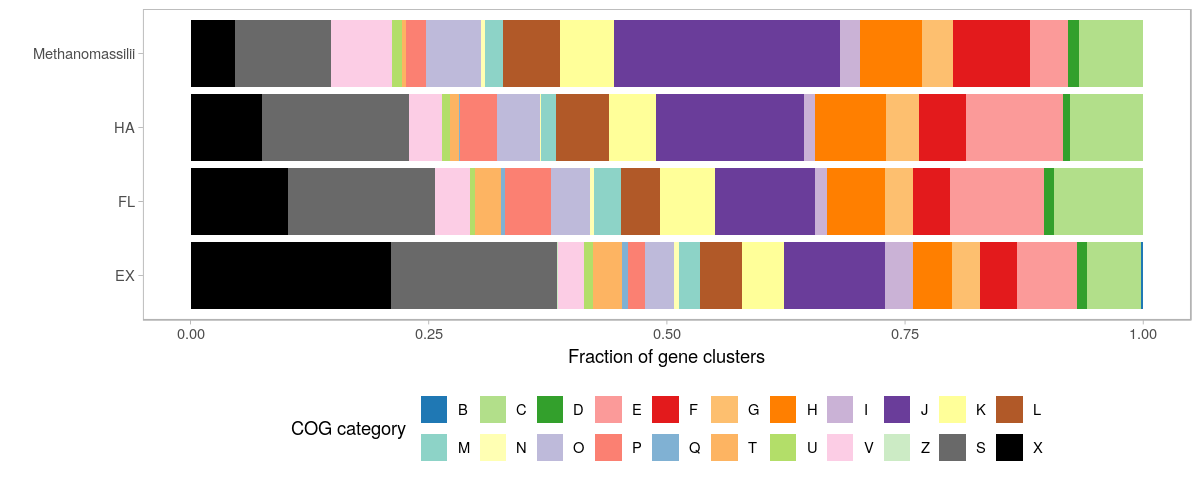

In [551]:
options(repr.plot.width = 10, repr.plot.height = 4)

cog_barplt = core_proportion_copies %>%
    mutate(Clade = fct_relevel(Clade, rev(levels(Clade)))) %>%
    ggplot(., aes(x = Clade, y = Proportion, fill = COG_1)) + 
        geom_bar(stat="identity", position="fill") + 
        scale_fill_manual(values=col_vector) +
        theme_light() +
        labs(y = "Fraction of gene clusters", x = " ", fill = "COG\nCategoty") +
        coord_flip() +
        theme(legend.position="bottom", 
              panel.grid.major = element_blank(), 
              panel.grid.minor = element_blank()) +
        guides(fill = guide_legend(title = "COG category", label.position = "right",
                                   nrow = 2, byrow = TRUE))

plot(cog_barplt)

## COG categories stats

In [552]:
# Mean of each COG category
COG_summaries_stats = core_proportion_copies %>% 
    filter(Clade != "Methanomassilii") %>%
    group_by(COG_1) %>% 
    summarise(mean_cog = mean(Proportion, na.rm = T), 
              sd_cog = sd(Proportion,  na.rm = T)) %>%
    arrange(-mean_cog)

COG_summaries_stats %>% filter(mean_cog >= 0.01)

COG_1,mean_cog,sd_cog
<fct>,<dbl>,<dbl>
S,16.07424407,1.1832449
X,12.92385821,7.1380783
J,12.19896601,2.8618641
E,8.81584591,2.1780534
C,7.52075918,1.8293430
H,5.88102614,1.7091516
K,5.03190132,0.7180064
L,4.65770062,0.7600163
F,4.21832805,0.5747908


In [668]:
# Unknowns per clade
core_proportion_copies %>%
    filter(COG_1 %in% c("X", "S")) %>%
    group_by(Clade) %>%
    summarise(Unkown = sum(Proportion))

Clade,Unkown
<chr>,<dbl>
EX,38.45083
FL,25.60849
HA,22.93498
Methanomassilii,14.71909


In [554]:
# Mean COG on complete dataset
genome_cluster_prop %>%
    group_by(COG_1) %>%
    summarise(mean = mean(prop), sd = sd(prop))

COG_1,mean,sd
<fct>,<dbl>,<dbl>
A,0.002441767,0.01181310
B,0.031581879,0.04292246
C,6.901639506,0.79457624
D,0.721546454,0.15904319
E,7.445520642,0.81418371
F,3.073729586,0.52862270
G,2.808990052,0.22238961
H,6.254969515,1.14205460
I,1.199428499,0.25352991


In [555]:
# Mean unknown COGs on complete dataset
genome_cluster_prop %>%
    filter(COG_1 %in% c("S", "X")) %>%
    select(-prop) %>%
    spread(COG_1, count) %>%
    mutate(unknowns = 100*((S + X)/total)) %>%
    summarise(mean = mean(unknowns), sd = sd(unknowns))
    

mean,sd
<dbl>,<dbl>
38.36757,4.308546


# Barplot and Size distribution combined plot

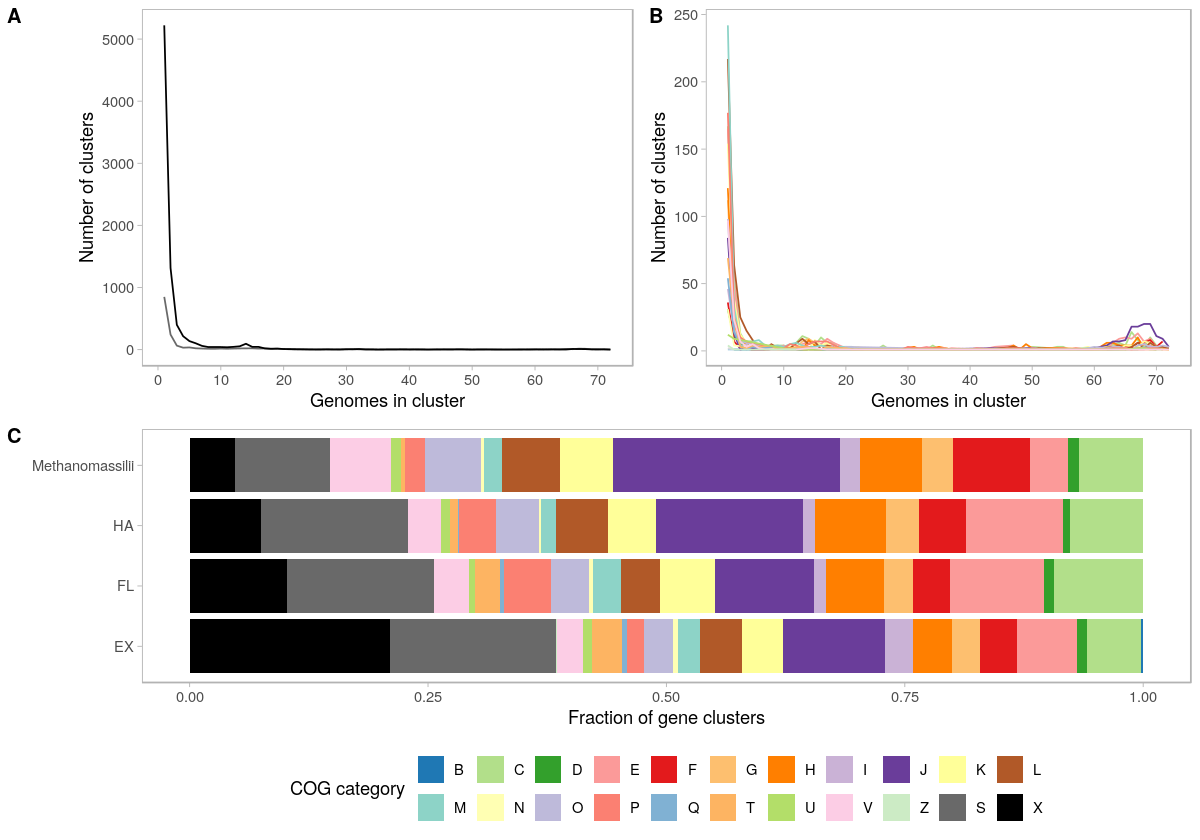

In [556]:
options(repr.plot.width = 10, repr.plot.height = 7)
# first align the top-row plot with the left-most plot of the bottom row
combined_left = align_plots(cog_barplt, Mmassilii_spectrum_u, align = 'v', axis = 'l')


# then build the top row
combined_top = plot_grid(combined_left[[2]], Mmassilii_spectrum_k, rel_widths = c(1.15, 1),
                        labels = c('A', 'B'), label_size = 12)

# then combine with the top row for final plot
combined_plot = plot_grid(combined_top, labels = c('', 'C'), combined_left[[1]],  label_size = 12, ncol = 1)
plot(combined_plot)

In [557]:
# Save plot
plot_file = file.path(plots_dir, "Combined_Cluster_COGs.png")
save_plot(filename = plot_file, plot = combined_plot,
          base_height = 7, base_width = 10, dpi = 300)

# Table with proportion of COG categories in the core of each clade

In [136]:
# Obtain the relative abundance of each COG category in the respective core of
# each genome

# Relabund of each COG category in the core of each genome of the HA clade
core_HA_relabund = cluster_table %>% 
    filter(MSA %in% core_HA$MSA) %>%
    select(MSA, COG_1, one_of(HA_clade)) %>%
    select(COG_1, starts_with("GCA"), V11_RL001) %>% 
    gather(Genome, Count, -COG_1) %>%
    aggregate(Count ~ COG_1 + Genome, ., sum) %>%
    spread(Genome, Count) %>%
    column_to_rownames("COG_1") %>%
    decostand(., method = "total", MARGIN = 2) %>%
    rownames_to_column("COG_1")

# Relabund of each COG category in the core of each genome of the FL clade
core_FL_relabund = cluster_table %>% 
    filter(MSA %in% core_FL$MSA) %>%
    select(MSA, COG_1, one_of(FL_clade)) %>%
    select(COG_1, starts_with("GCA")) %>% 
    gather(Genome, Count, -COG_1) %>%
    aggregate(Count ~ COG_1 + Genome, ., sum) %>%
    spread(Genome, Count) %>%
    column_to_rownames("COG_1") %>%
    decostand(., method = "total", MARGIN = 2) %>%
    rownames_to_column("COG_1")

# Relabund of each COG category in the core of each genome of the EX clade
core_EX_relabund = cluster_table %>% 
    filter(MSA %in% core_EX$MSA) %>%
    select(MSA, COG_1, one_of(EX_clade)) %>%
    select(COG_1, starts_with("GCA")) %>% 
    gather(Genome, Count, -COG_1) %>%
    aggregate(Count ~ COG_1 + Genome, ., sum) %>%
    spread(Genome, Count) %>%
    column_to_rownames("COG_1") %>%
    decostand(., method = "total", MARGIN = 2) %>%
    rownames_to_column("COG_1")

cores_relabund = full_join(core_HA_relabund, core_FL_relabund, by = "COG_1") %>%
    full_join(., core_EX_relabund, by = "COG_1") 

cores_relabund[is.na(cores_relabund)] = 0

# Transpose table
cores_COG_relabund = cores_relabund %>%
    gather(Genome, relabund, -COG_1) %>%
    spread(COG_1, relabund)

clades_Genome = methanomassilii_data_raw %>%
    select(Genome = Assembly, clade)

cores_COG_relabund = full_join(cores_COG_relabund, clades_Genome,  by = "Genome")

In [185]:
# Save tables
make_dir(dir = "/ebio/abt3_projects/vadinCA11/data/V11/COG_tables")
write_tsv(cores_COG_relabund, "/ebio/abt3_projects/vadinCA11/data/V11/COG_tables/COG_cores_relabund.tsv")
write_tsv(core_proportion_copies, "/ebio/abt3_projects/vadinCA11/data/V11/COG_tables/COG_cores_clade.tsv")


Directory already exists: /ebio/abt3_projects/vadinCA11/data/V11/COG_tables 


# Methanogenesis genes

In [40]:
Methano_core_count %>% dfhead
Methano_core_annot %>% dfhead

[1] 72 31


Assembly,arCOG04888,arCOG02822,arCOG03226,arCOG04904,arCOG02679,arCOG04903,arCOG04901,arCOG04900,arCOG03225,⋯,arCOG00950,arCOG04866,arCOG03221,arCOG04867,arCOG04868,arCOG04869,arCOG04870,arCOG01579,arCOG04844,arCOG04885
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
GCA_002508585,1,0,1,1,1,1,1,1,1,⋯,0,0,0,0,0,0,0,0,0,0
GCA_002502005,1,1,1,1,1,1,0,0,1,⋯,0,0,0,0,0,0,0,0,0,0
GCA_002505225,1,1,1,1,1,1,1,1,1,⋯,0,0,0,0,0,0,0,0,0,0


[1] 30  3


arCOGs,Distribution,Product
<fct>,<fct>,<fct>
arCOG04888,1,Nitrogenase molybdenum-iron like protein (NifD-like/NflD)
arCOG02822,1,UDP-N-acetylmuramyl pentapeptide synthase like protein (MurF-like)
arCOG03226,1,Methyl-coenzyme M reductase operon associated like protein (McrC-like)


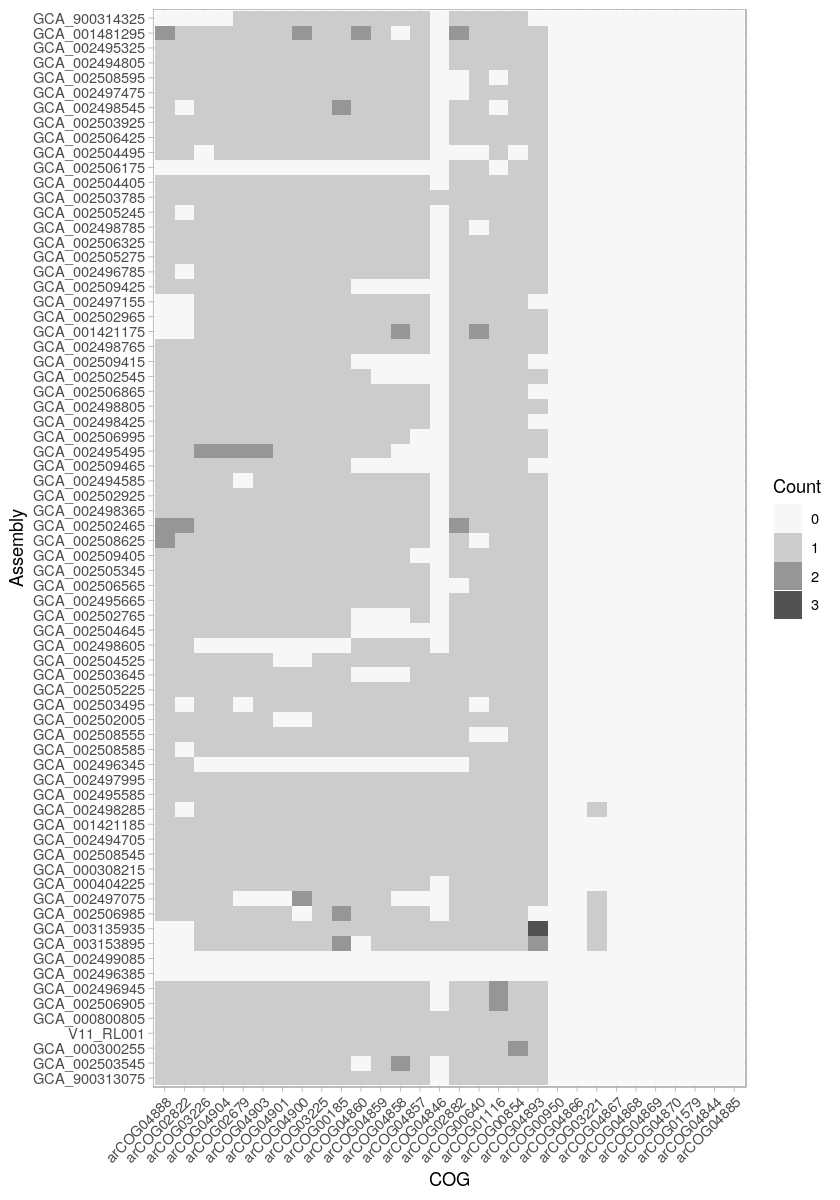

In [41]:
options(repr.plot.width = 7, repr.plot.height = 10)
Methano_heatmap_df = Methano_core_count %>%
    gather(COG, Count, -Assembly) %>%
    mutate(COG = factor(COG, levels = Methano_core_annot$arCOGs), 
           Count = factor(Count), 
           Assembly = factor(Assembly, levels = phylogenomic_tree$tip.label))
    
Methano_core_heatmap = Methano_heatmap_df %>%
    ggplot(aes(x = COG, y = Assembly, fill = Count)) + 
    geom_tile() +
    theme_light() +
    #scale_fill_viridis_d() +
    #scale_fill_gradient(low = "white", high = "steelblue") +
    scale_fill_brewer(palette = "Greys") +
    theme(axis.text.x = element_text(angle = 45, hjust = 1))

plot(Methano_core_heatmap)

In [42]:
# Itol heatmap
Methano_core_count %>%
    column_to_rownames("Assembly") %>% 
    itol_heatmap(df = ., dataset_label = "Core_methanogenesis", 
                    out_file = "Methanogenesis_heat.txt", out_dir =  itol_dir, 
                 dist_method='euclidean', color_scheme="bw")

File written: /ebio/abt3_projects/vadinCA11/data/V11/itol/Methanogenesis_heat.txt 


# Create ITOL files

In [43]:
ELP_Sum_export %>% dfhead

[1] 72 10


Assembly,ALP,ANK,FN3,Ig_like,List_Bact,LRR,Sel1,TPR,YadA
<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
GCA_000300255,0,0,0,0,6,1,28,37,0
GCA_000308215,2,0,5,1,2,5,1,11,0
GCA_000404225,1,1,0,1,26,7,6,15,0


In [44]:
# Labels used in tree (Manually created)
itol_labels = file.path(itol_dir, "labels.txt") %>% 
    read.table(file = ., skip = 3, sep = ",", col.names = c("Assembly", "Label"))

methanomassilii_data = methanomassilii_data_raw %>%  
    left_join(., itol_labels, by = "Assembly") %>% 
    left_join(., ELP_Sum_export,  by = "Assembly") %>%
    mutate(GC = GC*100, Len = Len/1000000,
           source_1 = as.factor(source_2),
           source_2 = as.factor(source_2),
           source_3 = as.factor(source_3),
           source_manual = as.factor(source_manual),
           location = as.factor(location))

methanomassilii_data

Warning message:
“Column `Assembly` joining character vector and factor, coercing into character vector”

Taxonomy,Assembly,GC,Len,Genes,source_1,source_2,source_3,source_manual,location,⋯,Label,ALP,ANK,FN3,Ig_like,List_Bact,LRR,Sel1,TPR,YadA
<chr>,<chr>,<dbl>,<dbl>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,⋯,<fct>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
Candidatus_Methanomethylophilus_alvus_Mx1201,GCA_000300255,55.59482,1.666795,1636,Feces,Feces,Human,Human_feces,NA,⋯,ca. Mmethylophilus alvus Mx1201,0,0,0,0,6,1,28,37,0
Methanomassiliicoccus_luminyensis_B10,GCA_000308215,60.47886,2.620233,2607,Feces,Feces,Human,Human_feces,NA,⋯,Mmassiliicoccus luminyensis B10,2,0,5,1,2,5,1,11,0
Candidatus_Methanomassiliicoccus_intestinalis_Issoire_Mx1,GCA_000404225,41.25543,1.931651,1855,Feces,Feces,Human,Human_feces,NA,⋯,ca. Mmassiliicoccus intestinalis Mx1,1,1,0,1,26,7,6,15,0
Candidatus_Methanoplasma_termitum,GCA_000800805,49.20570,1.488669,1419,Gut content,Gut content,Termite,Termite_gut,Kenya,⋯,ca. Mplasma termitum,4,3,0,2,7,0,10,21,0
Methanomassiliicoccales_archaeon_RumEn_M2,GCA_001421175,54.60069,1.280797,1497,Rumen,Rumen,Cow,Cow_rumen,Austria,⋯,Mmassiliicoccales RumEn M2,0,0,2,0,3,5,9,17,0
Methanomassiliicoccales_archaeon_RumEn_M1,GCA_001421185,62.09410,2.121026,2515,Rumen,Rumen,Cow,Cow_rumen,Austria,⋯,Mmassiliicoccales RumEn M1,2,0,1,1,2,0,0,11,0
Candidatus_Methanomethylophilus_sp_1R26,GCA_001481295,60.39454,1.723106,2079,Rumen,Rumen,Cow,Cow_rumen,Denmark,⋯,ca. Mmethylophilus 1R26,0,0,0,0,13,8,29,40,0
Methanomassiliicoccaceae_archaeon_UBA409,GCA_002494585,55.76718,1.292133,1369,Reactor,Reactor,Mud,Fermentation_reactor,China,⋯,Mmassiliicoccaceae UBA409,0,0,0,0,0,0,9,16,0
Methanomassiliicoccus_sp_UBA238,GCA_002494705,58.97788,1.711594,1799,Digester,Digester,Manure,Biogas_plant_manure,Denmark,⋯,Mmassiliicoccus UBA238,1,0,1,1,0,3,0,7,0


In [45]:
# Create color strip of microbe source_1
methanomassilii_data %>% 
    column_to_rownames("Assembly") %>%
    select(source_1) %>% 
    itol_colorstrip(df = ., dataset_label = "Environment", 
                    out_file = "source1_colorstrip.txt", out_dir =  itol_dir)

# Create color strip of microbe source_2
methanomassilii_data %>% 
    column_to_rownames("Assembly") %>% 
    select(source_2) %>% 
    itol_colorstrip(df = ., dataset_label = "Source", 
                    out_file = "source2_colorstrip.txt", out_dir =  itol_dir)

# Create color strip of microbe source_3
methanomassilii_data %>% 
    column_to_rownames("Assembly") %>% 
    select(source_3) %>% 
    itol_colorstrip(df = ., dataset_label = "Sample", 
                    out_file = "source3_colorstrip.txt", out_dir =  itol_dir)

# Create color strip of microbe source manual
methanomassilii_data %>% 
    column_to_rownames("Assembly") %>% 
    select(source_manual) %>% 
    itol_colorstrip(df = ., dataset_label = "Isolation_source", 
                    out_file = "sourceM_colorstrip.txt", out_dir =  itol_dir)

File written: /ebio/abt3_projects/vadinCA11/data/V11/itol/source1_colorstrip.txt 
File written: /ebio/abt3_projects/vadinCA11/data/V11/itol/source2_colorstrip.txt 
File written: /ebio/abt3_projects/vadinCA11/data/V11/itol/source3_colorstrip.txt 
File written: /ebio/abt3_projects/vadinCA11/data/V11/itol/sourceM_colorstrip.txt 


In [46]:
# Change Colors in colorstrips

"sed -i -e 's/#FF0000/#d67622/' -e 's/#00FF00/#616163/' -e 's/#0000FF/#c2d8b9/' /ebio/abt3_projects/vadinCA11/data/V11/itol/source1_colorstrip.txt" %>% system

"sed -i -e 's/#FF0000/#A6CEE3/g' -e 's/#FF8B00/#1F78B4/g' -e 's/#E8FF00/#B2DF8A/g' -e 's/#5DFF00/#33A02C/g' -e 's/#00FF2E/#FB9A99/g' -e 's/#00FFB9/#E31A1C/g' -e 's/#00B9FF/#FDBF6F/g' -e 's/#002EFF/#FF7F00/g' -e 's/#5D00FF/#CAB2D6/g' -e 's/#E800FF/#6A3D9A/g' -e 's/#FF008/#FFFF99/g' /ebio/abt3_projects/vadinCA11/data/V11/itol/sourceM_colorstrip.txt" %>% system

In [47]:
methanomassilii_data %>% 
    select(Assembly, ALP, ANK, FN3, Ig_like, List_Bact, LRR, Sel1, TPR, YadA) %>%
    mutate_if(is.numeric, .f = function(x) x/max(x)) %>% 
    column_to_rownames("Assembly") %>% 
    itol_heatmap(df = ., dataset_label = "Adhesion_proteins", 
                 color_scheme = "bw",
                 out_file = "Prots_heatmap.txt", out_dir =  itol_dir)
              
methanomassilii_data %>% 
    select(Assembly, GC, Len, Genes) %>%
    mutate_if(is.numeric, .f = function(x) x/max(x)) %>% 
    column_to_rownames("Assembly") %>% 
    itol_heatmap(df = ., dataset_label = "Genome_Characteristics", 
                 color_scheme = "bw",
                 out_file = "Feats_heatmap.txt", out_dir =  itol_dir)

File written: /ebio/abt3_projects/vadinCA11/data/V11/itol/Prots_heatmap.txt 
File written: /ebio/abt3_projects/vadinCA11/data/V11/itol/Feats_heatmap.txt 


In [48]:
itol_file = function(Itol_df, to_rownames, to_itol, sufix = "shape", directory){
    var_name = deparse(substitute(to_itol))
    row_name = deparse(substitute(to_rownames))
    Itol_df %>%
    column_to_rownames(row_name) %>%
    select({{to_itol}}) %>%
    itol_externalshape(df = ., 
                       dataset_label = var_name, 
                       out_dir =  itol_dir,
                       out_file = glue::glue("{varname}_{sfx}.txt", 
                                       varname = var_name, sfx = sufix)) 
                       
}

In [264]:
itol_file(methanomassilii_data, to_rownames = Assembly, 
    to_itol = GC, sufix = "shape", directory = itol_dir)

itol_file(methanomassilii_data, to_rownames = Assembly, 
    to_itol = Len, sufix = "shape", directory = itol_dir)

itol_file(methanomassilii_data, to_rownames = Assembly, 
    to_itol = Genes, sufix = "shape", directory = itol_dir)

itol_file(methanomassilii_data, to_rownames = Assembly, 
    to_itol = ALP, sufix = "shape", directory = itol_dir)

itol_file(methanomassilii_data, to_rownames = Assembly, 
    to_itol = ANK, sufix = "shape", directory = itol_dir)

itol_file(methanomassilii_data, to_rownames = Assembly, 
    to_itol = FN3, sufix = "shape", directory = itol_dir)

itol_file(methanomassilii_data, to_rownames = Assembly, 
    to_itol = Ig_like, sufix = "shape", directory = itol_dir)

itol_file(methanomassilii_data, to_rownames = Assembly, 
    to_itol = List_Bact, sufix = "shape", directory = itol_dir)

itol_file(methanomassilii_data, to_rownames = Assembly, 
    to_itol = LRR, sufix = "shape", directory = itol_dir)

itol_file(methanomassilii_data, to_rownames = Assembly, 
    to_itol = Sel1, sufix = "shape", directory = itol_dir)

itol_file(methanomassilii_data, to_rownames = Assembly, 
    to_itol = TPR, sufix = "shape", directory = itol_dir)

itol_file(methanomassilii_data, to_rownames = Assembly, 
    to_itol = YadA, sufix = "shape", directory = itol_dir)


File written: /ebio/abt3_projects/vadinCA11/data/V11/itol/GC_shape.txt 
File written: /ebio/abt3_projects/vadinCA11/data/V11/itol/Len_shape.txt 
File written: /ebio/abt3_projects/vadinCA11/data/V11/itol/Genes_shape.txt 
File written: /ebio/abt3_projects/vadinCA11/data/V11/itol/ALP_shape.txt 
File written: /ebio/abt3_projects/vadinCA11/data/V11/itol/ANK_shape.txt 
File written: /ebio/abt3_projects/vadinCA11/data/V11/itol/FN3_shape.txt 
File written: /ebio/abt3_projects/vadinCA11/data/V11/itol/Ig_like_shape.txt 
File written: /ebio/abt3_projects/vadinCA11/data/V11/itol/List_Bact_shape.txt 
File written: /ebio/abt3_projects/vadinCA11/data/V11/itol/LRR_shape.txt 
File written: /ebio/abt3_projects/vadinCA11/data/V11/itol/Sel1_shape.txt 
File written: /ebio/abt3_projects/vadinCA11/data/V11/itol/TPR_shape.txt 
File written: /ebio/abt3_projects/vadinCA11/data/V11/itol/YadA_shape.txt 


# Session info

In [49]:
sessionInfo()

R version 3.5.1 (2018-07-02)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Ubuntu 18.04.4 LTS

Matrix products: default
BLAS/LAPACK: /ebio/abt3_projects/software/miniconda3_gt4.4/envs/UpSetR_2/lib/R/lib/libRlapack.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] vegan_2.5-5        lattice_0.20-38    permute_0.9-5      cowplot_1.0.0     
 [5] phangorn_2.5.5     ape_5.3            RColorBrewer_1.1-2 reshape2_1.4.3    
 [9] UpSetR_1.4.0       data.table_1.12.2  forcats_0.4.0      stringr_1.4.0     
[13] dplyr_0.8.3        purrr_0.3.2 

# Archaelum clusters by clade

In [50]:
eggNOG_MSAs = cluster_table %>% 
    filter(str_detect(eggNOG_annot, "flag") | 
           str_detect(eggNOG_annot, "pilin") | 
           str_detect(eggNOG_annot, "secretion system")) %>% 
    pull(MSA)

interpro_MSAs = cluster_table %>% 
    filter(str_detect(Interpro_annot, "flag") | 
           str_detect(Interpro_annot, "pilin") | 
           str_detect(Interpro_annot, "secretion system")) %>% 
    pull(MSA)

prokka_MSAs = cluster_table %>% 
    filter(str_detect(Annotation, "flag") | 
           str_detect(Annotation, "pilin") | 
           str_detect(Annotation, "secretion system")) %>% 
    pull(MSA)

Archaellum_MSAs = c(eggNOG_MSAs, interpro_MSAs, prokka_MSAs) %>% 
    unique

Archaellum_clusters = cluster_table %>% 
    filter(MSA %in% Archaellum_MSAs)

Archaellum_clusters %>% dfhead

[1] 31 82


Gene_ID,MSA,Gene_Name,Annotation,Count,NOG,COG_1,eggNOG_annot,Interpro_accession,Interpro_annot,⋯,GCA_002508625,GCA_002509405,GCA_002509415,GCA_002509425,GCA_002509465,GCA_003135935,GCA_003153895,GCA_900313075,GCA_900314325,V11_RL001
<int>,<chr>,<chr>,<chr>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
620,GC00000098_4,None,hypothetical protein,62,COG0630@NOG,N,secretion system protein,IPR001482,Type II/IV secretion system protein,⋯,1,0,1,1,1,1,1,0,1,1
678,GC00000259_r1_r1_1,flaK,Preflagellin peptidase,59,COG1989@NOG,N,Inherit from arCOG: peptidase,IPR009655,"Preflagellin peptidase, C-terminal",⋯,1,0,1,1,1,1,1,1,1,1
689,GC00000575_r1_r1_r1_1,None,hypothetical protein,58,0Z5FY@NOG,S,Inherit from eurNOG: type ii secretion system,IPR018076,Type II secretion system F domain,⋯,1,0,1,1,1,0,0,1,1,1


In [51]:
Archaellum_clusters %>% 
    select(MSA, Count, ends_with("annot"), HA_clade) %>% 
    arrange(-V11_RL001)

MSA,Count,eggNOG_annot,Interpro_annot,GCA_002504405,GCA_002506175,GCA_002504495,GCA_002506425,GCA_002503925,GCA_002494805,⋯,GCA_002508625,GCA_002498425,GCA_002498805,GCA_002502925,GCA_002502465,GCA_002498365,GCA_002506995,GCA_002494585,GCA_002509465,GCA_002495495
<chr>,<int>,<fct>,<fct>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
GC00000098_4,62,secretion system protein,Type II/IV secretion system protein,1,1,1,1,2,1,⋯,1,2,2,1,1,1,2,1,1,1
GC00000259_r1_r1_1,59,Inherit from arCOG: peptidase,"Preflagellin peptidase, C-terminal",0,0,0,0,0,0,⋯,1,1,1,1,1,1,1,1,1,1
GC00000575_r1_r1_r1_1,58,Inherit from eurNOG: type ii secretion system,Type II secretion system F domain,1,0,1,1,1,1,⋯,1,1,1,1,1,1,1,1,1,1
GC00000098_3,21,type II secretion system protein,Type II/IV secretion system protein,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
GC00001195_3,20,type II secretion system protein,Type II secretion system F domain,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
GC00001198,20,Protein of unknown function (DUF1628),"Archaeal Type IV pilin, N-terminal",0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
GC00001262,19,Type II secretion system,Type II secretion system F domain,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
GC00001044_r1_r1_r1_1,17,NA,"Archaeal Type IV pilin, N-terminal",0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
GC00000259_2,6,NA,"Prepilin type IV endopeptidase, peptidase domain",0,0,0,2,1,1,⋯,0,0,0,0,0,0,0,0,0,0


In [52]:
Archaellum_clusters_long = Archaellum_clusters %>% 
    select(matches("annot"), starts_with("GCA"), starts_with("V11")) %>%
    gather(Assembly, Count, -c(Annotation, eggNOG_annot, Interpro_annot))

Archaellum_clusters_sum = Archaellum_clusters_long %>% 
    group_by(Assembly) %>% 
    summarise(Arch_clusters = sum(Count)) %>% 
    left_join(., df_Clade)

Archaellum_clusters_sum %>% 
    group_by(clade) %>% 
    summarise(mean = mean(Arch_clusters), min = min(Arch_clusters), max = max(Arch_clusters))

Joining, by = "Assembly"


clade,mean,min,max
<chr>,<dbl>,<int>,<int>
EX,12.00,12,12
FL,10.50,0,18
HA,3.04,0,8


# Debug

## Corrinoid Proteins

In [514]:
# Table with gene names and substrate
Methyl_methanogenesis_genes = c("mtbA", "mttB", "mttC", "mtbB1", "mtbB2", 
                                "mtbC", "mtmB1", "mtaA", "mtaB", "mtsA")

substrate_path = c("XMA", "TMA", "TMA", "DMA", "DMA", "DMA", "MMA", "Methanol", "Methanol", "Methylthiol/DMS")


Methyl_path_names = data.frame(Methyl_methanogenesis_genes, substrate_path)
Methyl_path_names

Methyl_methanogenesis_genes,substrate_path
<fct>,<fct>
mtbA,XMA
mttB,TMA
mttC,TMA
mtbB1,DMA
mtbB2,DMA
mtbC,DMA
mtmB1,MMA
mtaA,Methanol
mtaB,Methanol


In [533]:
# Table of corinoid proteins for heatmap
Methyl_methanogenesis_clusters = cluster_table %>%
    mutate(Gene_Name_simple = str_remove(Gene_Name, "\\_.*")) %>%
    filter(Gene_Name_simple %in% Methyl_methanogenesis_genes) %>%
    arrange(Gene_Name_simple)


Methyl_aggregated_clusters = Methyl_methanogenesis_clusters %>%
    select(Gene_Name_simple, starts_with("GCA_"), starts_with("V11_")) %>%
    aggregate(. ~ Gene_Name_simple, ., sum) %>%
    gather(Assembly, count, -Gene_Name_simple) %>%
    mutate(Gene_Name_simple = factor(Gene_Name_simple, 
                                     levels = Methyl_methanogenesis_genes), 
           Assembly = factor(Assembly, 
                             levels = phylogenomic_tree$tip.label))
    
    
Methyl_aggregated_clusters %>% dfhead

[1] 720   3


Gene_Name_simple,Assembly,count
<fct>,<fct>,<int>
mtaA,GCA_000300255,0
mtaB,GCA_000300255,1
mtbA,GCA_000300255,6


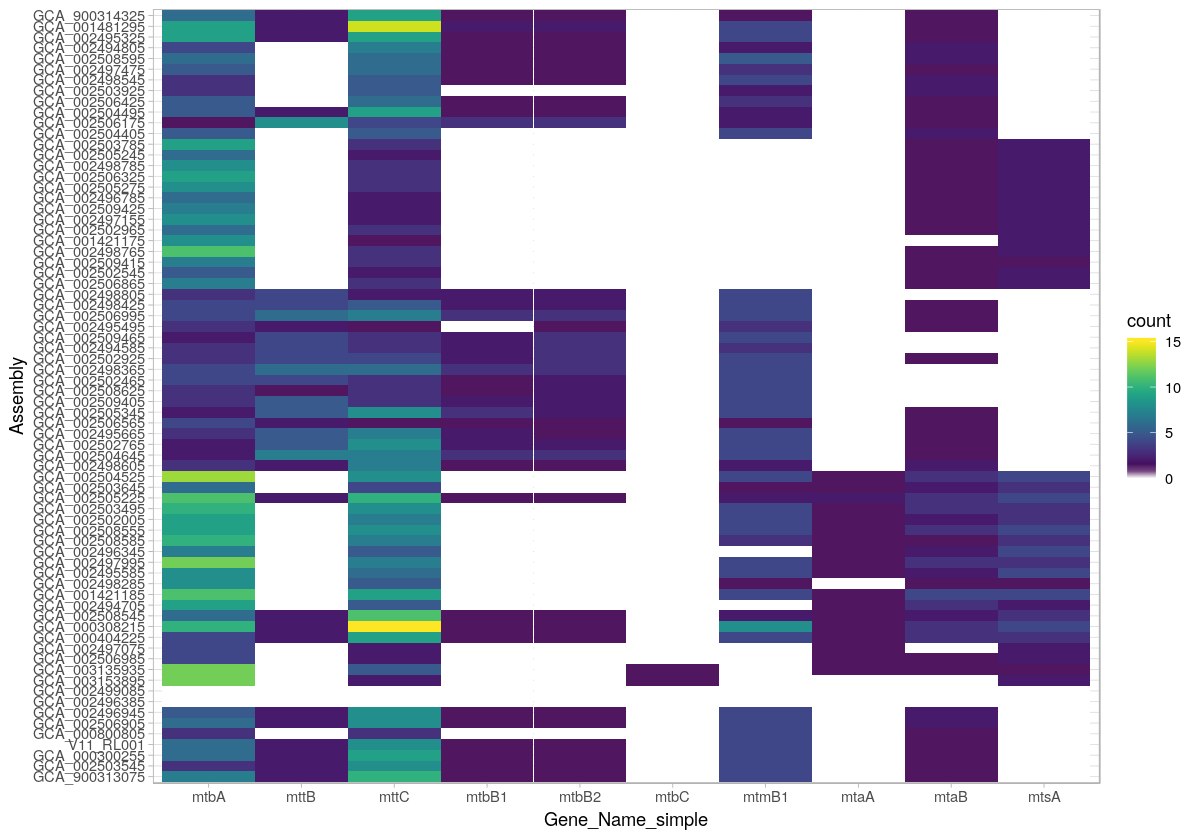

In [534]:
heatmap_palette = c("#FFFFFF", viridisLite::viridis(n = 14))

Methyl_aggregated_clusters %>%
    ggplot(aes(x = Gene_Name_simple, y = Assembly, fill = count)) +
    geom_tile() +
    theme_light() +
    #scale_fill_viridis_c()
    scale_fill_gradientn(colours = heatmap_palette)


In [545]:
Methyl_aggregated_clusters %>%
    spread(Gene_Name_simple, count) %>%
    column_to_rownames("Assembly") %>%
    itol_heatmap(., 
                 dataset_label = "Corrinoid_Proteins", 
                 out_file = file.path(itol_dir, "Corrinoid_heatmap.txt"), 
                 color_scheme = "bw")

File written: /ebio/abt3_projects/vadinCA11/data/V11/itol/Corrinoid_heatmap.txt 


## Clusters of outlier taxa

In [576]:
core_HA %>% dfhead

[1] 767  85


Gene_ID,MSA,Gene_Name,Annotation,Count,NOG,COG_1,eggNOG_annot,Interpro_accession,Interpro_annot,⋯,GCA_002509425,GCA_002509465,GCA_003135935,GCA_003153895,GCA_900313075,GCA_900314325,V11_RL001,Count_HA,Count_FL,Count_EX
<int>,<chr>,<chr>,<chr>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,GC00000267,None,GPN-loop GTPase,72,COG1100@NOG,S,Conserved hypothetical ATP binding protein,IPR004130,GPN-loop GTPase,⋯,1,1,1,1,1,1,1,50,20,2
2,GC00000268,None,hypothetical protein,72,COG1813@NOG,K,transcriptional regulator XRE family,IPR001387,Cro/C1-type helix-turn-helix domain,⋯,1,1,1,1,1,1,1,50,20,2
3,GC00000291,top6A,Type 2 DNA topoisomerase 6 subunit A,72,COG1697@NOG,L,DNA topoisomerase VI subunit A (EC 5.99.1.3),IPR004085,"DNA topoisomerase VI, subunit A",⋯,1,1,1,1,1,1,1,50,20,2


In [667]:
outlier_taxa = c("GCA_000308215", "GCA_002508545", "GCA_000404225", "GCA_001421185", "GCA_002498285")
core_HA %>%
    filter(!(MSA %in% core_Mmassilii$MSA)) %>%
    select(MSA, Annotation, NOG, eggNOG_annot, Interpro_accession, Interpro_annot,
           Count_HA, Count_FL, Count_EX, one_of(outlier_taxa)) %>%
    mutate(Count_outlier = (GCA_000308215 + GCA_002508545 + GCA_000404225 + GCA_001421185 + GCA_002498285)) %>%
    filter(Count_outlier > 0, Count_EX == 0, Count_FL < 10) %>% 
    arrange(-Count_outlier) %>%
    select(MSA, Count_outlier, everything())

MSA,Count_outlier,Annotation,NOG,eggNOG_annot,Interpro_accession,Interpro_annot,Count_HA,Count_FL,Count_EX,GCA_000308215,GCA_002508545,GCA_000404225,GCA_001421185,GCA_002498285
<chr>,<dbl>,<chr>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
GC00000109_r1_1_p1,3,Fe(2+) transporter FeoB,COG0370@NOG,Ferrous iron transport protein b,IPR030389,FeoB-type guanine nucleotide-binding (G) domain,46,4,0,1,0,1,1,0
GC00000891,3,hypothetical protein,COG1918@NOG,Ferrous iron transport protein A,IPR007167,Ferrous iron transporter FeoA domain,44,4,0,1,0,1,1,0
GC00000730_5,2,hypothetical protein,COG3428@NOG,membrane-flanked domain protein,IPR005182,Domain of unknown function DUF304,48,9,0,0,1,0,1,0
GC00000053_r1_1_p2_p2,2,Putative nickel-responsive regulator,COG0864@NOG,NikR C terminal nickel binding domain,IPR014864,"Transcription factor, NikR, nickel binding C-terminal",48,7,0,1,0,0,0,1
GC00000825_r1_1,2,hypothetical protein,COG1108@NOG,ABC transporter,IPR037294,"ABC transporter, BtuC-like",44,5,0,1,0,0,0,1
GC00000838,1,hypothetical protein,NA,NA,NA,NA,48,3,0,1,0,0,0,0
GC00000878,1,Formyltetrahydrofolate deformylase,COG3830@NOG,UPF0237 protein,IPR022986,"Uncharacterised protein family UPF0237, ACT-type",47,1,0,0,0,1,0,0
GC00000188_r1_r1_1,1,hypothetical protein,1102G@NOG,Protein of unknown function (DUF1638),IPR012437,Domain of unknown function DUF1638,45,3,0,0,1,0,0,0
GC00000074_r1_r1_r1_1_p1,1,Putative arsenical resistance operon repressor ArsR,COG0640@NOG,"Transcriptional regulator, arsr family",IPR001845,HTH ArsR-type DNA-binding domain,46,1,0,1,0,0,0,0
